In [1]:
# A component is replaced after the average lifetime. However, since the lifetime estimate of a component is
# always on the low side in order to minimize the number of failures, this often leads to unnecessary component
# replacement and a waste of money. These problems can be overcome by the utilization of condition monitoring
# systems (CMSs), which can be more beneficial than corrective and preventive maintenance since they allow early
# warnings of mechanical and electrical defects to prevent major component failures.

In [2]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm

import torch

In [3]:
cwd = os.getcwd()
cwd

'/u/51/avonscha/data/Desktop/Houston Analytics Pre-Assignment with data_English 3/Houston Analytics Pre-Assignment with data_English 3'

In [4]:
os.listdir(cwd) # returns list

['sensor_timeseries.pdf',
 'Component_changes.csv',
 'hourly_data.pdf',
 'component_changes_interpolated.pdf',
 'Shutdowns.csv',
 'all_data.pdf',
 'sensor_timeseries_without_shutdowns.pdf',
 'Sensor_measurements.csv',
 'component_changes.pdf',
 'Histogrammit.ipynb',
 'test_script.ipynb',
 '.ipynb_checkpoints',
 'Houston Analytics Pre-assignment_english.pdf']

# 1) Import sensor measurements

In [5]:
sensor_measurements = pd.read_csv('Sensor_measurements.csv', sep=';')
#sensor_measurements.head(5)

In [6]:
sensor_measurements = sensor_measurements.groupby(['sensor_name','meas_dttm', 'value'])['sensor_name'].agg(['count']).reset_index()

In [7]:
sensor_measurements = sensor_measurements.pivot_table(values='value', columns='sensor_name', index='meas_dttm')

In [8]:
sensor_measurements.index = pd.to_datetime(sensor_measurements.index)
sensor_measurements.index.names = ['Date']
#sensor_measurements.head(3)
#Order Sensor data columns

#### Plot sensor time series

# 2) Remove shutdowns

In [9]:
shutdowns = pd.read_csv('Shutdowns.csv', sep=';')
shutdowns.index = pd.to_datetime(shutdowns.shutdown_start_dttm)
#idx = pd.period_range(min(df2.index), max(df2.index), freq)
#shutdowns.reindex(idx, fill_value=0)

In [10]:
shutdowns["shutdown_start_dttm"] = pd.to_datetime(shutdowns["shutdown_start_dttm"])
shutdowns["shutdown_end_dttm"] = pd.to_datetime(shutdowns["shutdown_end_dttm"])
#shutdowns["duration"] = (shutdowns.shutdown_end_dttm-shutdowns.shutdown_start_dttm).astype('timedelta64[m]')
#shutdowns.head(3)
#len(shutdowns.shutdown_start_dttm)

In [11]:
mask = ((sensor_measurements.index >= shutdowns.shutdown_start_dttm[0]) & (sensor_measurements.index <= shutdowns.shutdown_end_dttm[0])) 
for i in range(1, len(shutdowns.shutdown_start_dttm)):
    mask |= ((sensor_measurements.index >= shutdowns.shutdown_start_dttm[i]) & (sensor_measurements.index <= shutdowns.shutdown_end_dttm[i])) 
sensor_measurements.loc[mask, :] = np.nan
#sensor_measurements.isna().sum()

#### Plot sensor time series without shutdowns

# 3) Create component changes dataframe

In [12]:
component_changes = pd.read_csv('Component_changes.csv', sep=';')
#component_changes.head(20)

In [13]:
component_changes.index = pd.to_datetime(component_changes.installation_dttm)
change_times = list(component_changes.installation_dttm.values)
#change_times

#### Plot sensor time series with component changes

In [14]:
# Drop Sensors 35 and 36 since they do not seem to have data
del sensor_measurements['Sensor35']
del sensor_measurements['Sensor36']
#sensor_measurements

In [15]:
# Interpolate missing values
# A better interpolation scheme could be used
sensor_measurements = sensor_measurements.interpolate()

In [16]:
sensor_measurements.columns

Index(['Sensor1', 'Sensor10', 'Sensor11', 'Sensor12', 'Sensor13', 'Sensor14',
       'Sensor15', 'Sensor16', 'Sensor17', 'Sensor18', 'Sensor19', 'Sensor2',
       'Sensor20', 'Sensor21', 'Sensor22', 'Sensor23', 'Sensor24', 'Sensor25',
       'Sensor26', 'Sensor27', 'Sensor28', 'Sensor29', 'Sensor3', 'Sensor30',
       'Sensor31', 'Sensor32', 'Sensor33', 'Sensor34', 'Sensor37', 'Sensor38',
       'Sensor39', 'Sensor4', 'Sensor40', 'Sensor41', 'Sensor42', 'Sensor43',
       'Sensor44', 'Sensor45', 'Sensor46', 'Sensor47', 'Sensor48', 'Sensor49',
       'Sensor5', 'Sensor50', 'Sensor51', 'Sensor52', 'Sensor53', 'Sensor6',
       'Sensor7', 'Sensor8', 'Sensor9'],
      dtype='object', name='sensor_name')

# 4) Create masterfile

In [17]:
#### Before doing hourly averages calculate Pearson correlations

#### Average to hourly data

In [18]:
hourly_averages = sensor_measurements.resample('H').mean()

In [19]:
#idx = pd.period_range(min(component_changes.installation_dttm), max(component_changes.installation_dttm), freq='H')
idx = pd.period_range(min(hourly_averages.index), max(hourly_averages.index), freq='H')

In [20]:
new_component_changes = component_changes.reindex(idx, fill_value=0)
new_component_changes['lifetime'] = 0
del new_component_changes['installation_dttm']
del new_component_changes['supplier']
del new_component_changes['sub_machine']
del new_component_changes['component_id']
#new_component_changes

In [21]:
j = 0
for i in range(0,new_component_changes.size):
    a=new_component_changes.index[i]
    if any(a.strftime('%Y-%m-%d %H:%M:%S') == c for c in change_times):
        j = 0
    new_component_changes.at[a, 'lifetime'] = j
    j += 1
#new_component_changes

In [22]:
new_component_changes.index.names = ['Date']
new_component_changes.index = new_component_changes.index.astype('datetime64[ns]') 
#new_component_changes

#### Concatenate sensor measurements and component changes

In [23]:
combined_df = new_component_changes.combine_first(hourly_averages)
#combined_df

# 5 Pearson correlation between component lifetime and sensor timeseries

In [24]:
### interpolation and hourly averaging should be done before?

In [25]:
### Sensor 42 best
### Periodicity, seasonality should be accounted for...maybe outliers?

In [26]:
#df = pd.read_csv('synchrony_sample.csv')
#overall_pearson_r = df.corr().iloc[0,1]
#print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

for i in range(0, len(combined_df.columns)):

    r, p = stats.pearsonr(combined_df.dropna()[combined_df.columns[i]], combined_df.dropna()['lifetime'])
    print(combined_df.columns[i])
    print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
#f,ax=plt.subplots(figsize=(7,3))
#combined_df.rolling(window=30,center=True).median().plot(ax=ax)
#ax.set(xlabel='Time',ylabel='Pearson r')
#ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Sensor1
Scipy computed Pearson r: -0.0875820788325429 and p-value: 0.0002937898107408707
Sensor10
Scipy computed Pearson r: -0.4938927044447331 and p-value: 1.5395609559680839e-105
Sensor11
Scipy computed Pearson r: 0.07908264918164461 and p-value: 0.0010824251800862425
Sensor12
Scipy computed Pearson r: -0.13255938631550668 and p-value: 3.932836179203932e-08
Sensor13
Scipy computed Pearson r: 0.35867856734479897 and p-value: 6.364301423403225e-53
Sensor14
Scipy computed Pearson r: 0.23279147993555893 and p-value: 2.047643356327464e-22
Sensor15
Scipy computed Pearson r: 0.15550552948108012 and p-value: 1.0773499436352409e-10
Sensor16
Scipy computed Pearson r: 0.10030292970847068 and p-value: 3.337812165626919e-05
Sensor17
Scipy computed Pearson r: -0.1286661633547852 and p-value: 9.7612133092028e-08
Sensor18
Scipy computed Pearson r: 0.22077796172108213 and p-value: 2.8717396934009885e-20
Sensor19
Scipy computed Pearson r: 0.19903387673510298 and p-value: 1.080940496308987e-16
Sensor2


# 6) Decomposition of the time series

In [27]:
#### https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621
#### Additive model:
#### y(t) = Level(t) + Trend(t) + Seasonality(t) + Noise(t)
#### Multiplicative model:
#### y(t) = Level(t) * Trend(t) * Seasonality(t) *Noise(t)

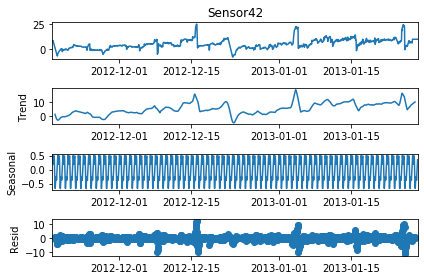

In [28]:
decomposition = sm.tsa.seasonal_decompose(combined_df['Sensor42'], model='additive')
fig = decomposition.plot()

In [29]:
for i in range(0, len(combined_df.columns)):
    decomposition = sm.tsa.seasonal_decompose(combined_df[combined_df.columns[i]], model='additive', extrapolate_trend='freq')
    #decomposition = sm.tsa.seasonal_decompose(combined_df[combined_df.columns[i]], model='multiplicative', extrapolate_trend='freq')
    #decomposition = sm.tsa.seasonal_decompose(combined_df['Sensor42'], model='multiplicative')
    #fig = decomposition.plot()
    r, p = stats.pearsonr(decomposition.trend, combined_df['lifetime'])
    print(combined_df.columns[i])
    print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Sensor1
Scipy computed Pearson r: -0.1013075884092392 and p-value: 2.778806716934798e-05
Sensor10
Scipy computed Pearson r: -0.5319853878574423 and p-value: 3.387877325786847e-125
Sensor11
Scipy computed Pearson r: 0.10066355427432888 and p-value: 3.125883495388486e-05
Sensor12
Scipy computed Pearson r: -0.1622874441518275 and p-value: 1.5737220700183586e-11
Sensor13
Scipy computed Pearson r: 0.3672401508177652 and p-value: 1.4011521379365367e-55
Sensor14
Scipy computed Pearson r: 0.2486887087625379 and p-value: 1.8977012118417933e-25
Sensor15
Scipy computed Pearson r: 0.1908979656857121 and p-value: 1.866215526656729e-15
Sensor16
Scipy computed Pearson r: 0.12195879974350438 and p-value: 4.393842684178488e-07
Sensor17
Scipy computed Pearson r: -0.16350190181967594 and p-value: 1.1053933815528989e-11
Sensor18
Scipy computed Pearson r: 0.23635174442315857 and p-value: 4.4787661348410055e-23
Sensor19
Scipy computed Pearson r: 0.20654606293508906 and p-value: 6.967765211231042e-18
Sensor2

In [30]:
print(len(combined_df['Sensor42']))
#print(len(combined_df['lifetime']))
decomposition.trend
r, p = stats.pearsonr(decomposition.trend, combined_df['lifetime'])
#print(combined_df.columns[i])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

1705
Scipy computed Pearson r: 0.9898043709850513 and p-value: 0.0


In [ ]:
# Save masterfile

In [34]:
combined_df.to_excel("output.xlsx")

In [31]:
# x) Sensor 42 is chosen as the output variable to describe component lifetime 

In [32]:
# a) Split data into train, validation, test
# a.2) scle data for model
# b) apply two different models
# c) feature select
# d) test

# 5) Train/test split

In [33]:
#X = series.values
train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

NameError: name 'X' is not defined

In [ ]:
class stockTickerDataset(torch.utils.data.Dataset):
    """This class is the dataset class which is used to load data for training the LSTM 
    to forecast timeseries data
    """

    def __init__(self, inputs, outputs):
        """Initialize the class with instance variables
        Args:
            inputs ([list]): [A list of tuples representing input parameters]
            outputs ([list]): [A list of floats for the stock price]
        """
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        """Returns the total number of samples in the dataset
        """
        return len(self.outputs)
    
    def __getitem__(self, idx):
        """Given an index, it retrieves the input and output corresponding to that index and returns the same
        Args:
            idx ([int]): [An integer representing a position in the samples]
        """
        x = torch.FloatTensor(self.inputs[idx])
        y = torch.FloatTensor([self.outputs[idx]])
        
        return (x, y)

# Do we need to scale the sensor data somehow?

In [ ]:
#### One method to accomplish this is standardization of the input data which in principle, converts all the input
#### parameters to have a mean of 0 and standard deviation of 1.

In [ ]:
def standardizeData(X, SS = None, train = False):
    """Given a list of input features, standardizes them to bring them onto a homogenous scale
    Args:
        X ([dataframe]): [A dataframe of all the input values]
        SS ([object], optional): [A StandardScaler object that holds mean and std of a standardized dataset]. Defaults to None.
        train (bool, optional): [If False, means validation set to be loaded and SS needs to be passed to scale it]. Defaults to False.
    """
    if train:
        SS = StandardScaler()   
        new_X = SS.fit_transform(X)
        return (new_X, SS)
    else:
        new_X = SS.transform(X)
        return (new_X, None)

In [ ]:
#### After having split the data into train and validation datasets and subsequently standardized the same, we will
#### create pytorch dataloaders in order to load the data and feed it to the pytorch model later on.

In [ ]:
def getDL(x, y, params):
    """Given the inputs, labels and dataloader parameters, returns a pytorch dataloader
    Args:
        x ([list]): [inputs list]
        y ([list]): [target variable list]
        params ([dict]): [Parameters pertaining to dataloader eg. batch size]
    """
    training_set = stockTickerDataset(x, y)
    training_generator = torch.utils.data.DataLoader(training_set, **params)
    return training_generator